<p style="text-align: center;">Jonas Holt Pedersen, 201905172</p>

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#### a) 
I selected the three stocks:

- Danske bank, DANSKE.CO

- NVIDIA, NVDA

- Novo Nordisk, NVO


They are all in USD starting from the date 05-05-2003, and I will be using the data from the daily closing price.

In [21]:
DK_close = pd.read_csv("DANSKE.CO.csv").to_numpy()[:,4].astype(float)
NVDA_close = pd.read_csv("NVDA.csv").to_numpy()[:,4].astype(float)
NVO_close = pd.read_csv("NVO.csv").to_numpy()[:,4].astype(float)

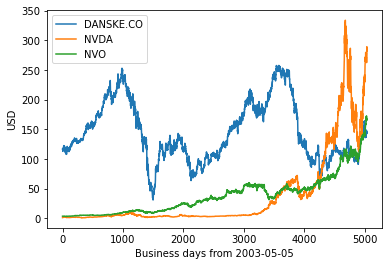

In [22]:
plt.plot(DK_close)
plt.plot(NVDA_close)
plt.plot(NVO_close)
plt.ylabel("USD")
plt.xlabel("Business days from 2003-05-05")
plt.legend(["DANSKE.CO", "NVDA", "NVO"])
plt.show()

#### b) Impleminting time delay
The "time_delay" function is defined below, and tested on the data, to verify it works.

In [23]:
def time_delay(data, d):
    k = len(data)
    new_data = np.array([data[j-d:j] for j in range(d,k+1)])
    return new_data

In [24]:
delay = 25
embed_DK = time_delay(DK_close, delay)
embed_NVO = time_delay(NVO_close, delay)
embed_NVDA = time_delay(NVDA_close, delay)

#### c) Sliding window
The code from the dealy function can be conveniently reused. And it is run again to verify that it works.

In [25]:
sliding_window = time_delay
window_size = 50
window_DK = sliding_window(embed_DK, window_size)
window_NVO = sliding_window(embed_NVO, window_size)
window_NVDA = sliding_window(embed_NVDA, window_size)

#### d) Advantages / Disadvantages of the size of $d$, and w.

- $d$

We notice, when the analysis is to be done, it will be done in $d$-dimensional space. Hence a disadvantage of choosing $d$ too large, will be the time required to compute the complexes.

In general, $d$, will determine how far back each data point will see. I am guessing setting this too large will smoothen out the variance of a vector, if the new coordiante makes up only a small amount of the overall vector. 

Putting it too small may have the opposite effect, in that, the data is too suseptible to high variance in price over a small amount of days. 
Furthermore, the amount of information each vector contains, may be to small to conclude any general patterns, mainly if it is as low as $1$ probably.


- $w$

We notice $w$ will be the number of points we consider for the analysis. We again have to worry about the time complexity of the algorithm when considering how large this should be. 

I suspect, we probably need a respecteble number of points to say anything general from the data. So a disadvantage of picking a small $w$ might be, that the complex will look like nothing. And that nothing can be concluded from it.

#### e) Methods to detect high volitility

Below is a plot of the average difference of windows, for all days $>w+d$, for $w=30$, $d=20$, for the three stoks. The function for the plots is below

In [26]:
def plot_mean_volit(window, price, name):
    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_title(name)
    ax1.set_xlabel('time (d)')
    ax1.set_ylabel('USD', color=color)
    ax1.plot(price[delay+window_size:], color=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    mean_window_diff = np.array(
        [np.mean(window[i+1] - window[i]) for i in range(len(window)-1)]
        )
    color = 'tab:orange'
    ax2.set_ylim(-3, 3)
    ax2.plot(mean_window_diff, color=color)
    fig.tight_layout() 
    plt.show()

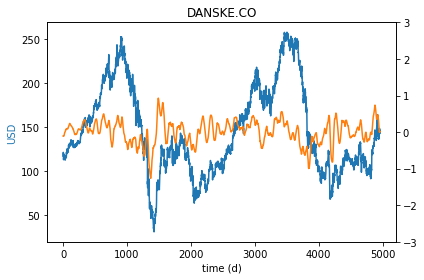

In [27]:
plot_mean_volit(window_DK, DK_close, "DANSKE.CO")

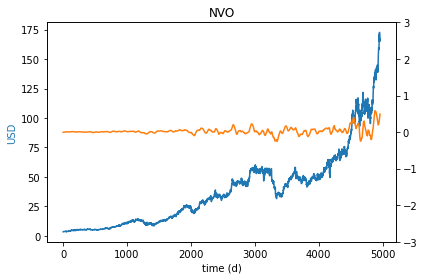

In [28]:
plot_mean_volit(window_NVO, NVO_close, "NVO")

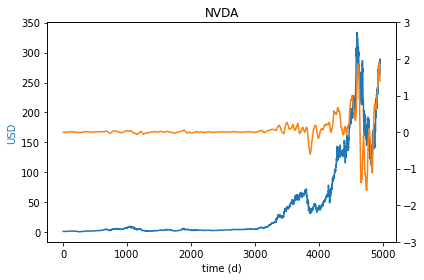

In [29]:
plot_mean_volit(window_NVDA, NVDA_close, "NVDA")

As seen above, this seems to spike when a period is volitile.

One could also look at the average price in the last $w+d$ days, and compare to the actual price. Then consider how much the price varies from the mean

In [30]:
def running_avr(prices, name, axes = plt):
    w_t = 100
    d_t = 1
    window_test = sliding_window(time_delay(prices,d_t),w_t)
    tmp = np.mean(window_test, axis=(1,2))
    axes.plot(prices[d_t+w_t:])
    axes.plot(tmp)
    axes.legend([name,"Mean"])

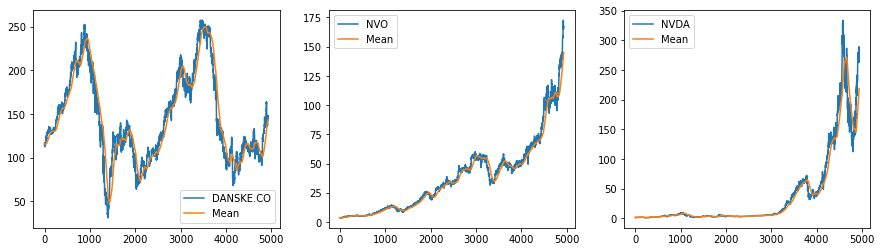

In [31]:
fig, ax = plt.subplots(1,3)
fig.set_figwidth(15)
running_avr(DK_close, "DANSKE.CO", ax[0])
running_avr(NVO_close, "NVO", ax[1])
running_avr(NVDA_close, "NVDA", ax[2])
plt.show()

#### f) Time-delay on log-returns, and persistance diagram on each window

I use Rips complexes to calculate the persistence diagram, since it is seemingly much faster than the alpha complexes, without loosing much precision.

In [32]:
# Compuping the log-returns
log_return = lambda x : np.diff(np.log(x))
log_return_DK = log_return(DK_close)
log_return_NVO = log_return(NVO_close)
log_return_NVDA = log_return(NVDA_close)

In [33]:
# Log returns embedding
dl = 2
wl = 40
log_windows_DK = sliding_window(time_delay(log_return_DK, dl),wl)
log_windows_NVO = sliding_window(time_delay(log_return_NVO, dl),wl)
log_windows_NVDA = sliding_window(time_delay(log_return_NVDA, dl),wl)

In [34]:
import gudhi as gd
def complex_persistence(window_data, comp_per = False):
    complex_out = []
    for window in window_data:
        cplx = gd.RipsComplex(points=window).create_simplex_tree(max_dimension = 2)
        if comp_per:
            cplx.persistence()
            complex_out.append(cplx.persistence_intervals_in_dimension(1))
        else:
            complex_out.append(cplx)
    return complex_out            

In [35]:
DK_complex = complex_persistence(log_windows_DK)
NVO_complex = complex_persistence(log_windows_NVO)
NVDA_complex = complex_persistence(log_windows_NVDA)

Below is plotted the persistance diagram of all the individual diagrams in one big one. Mostly for the sake of a sanity check.

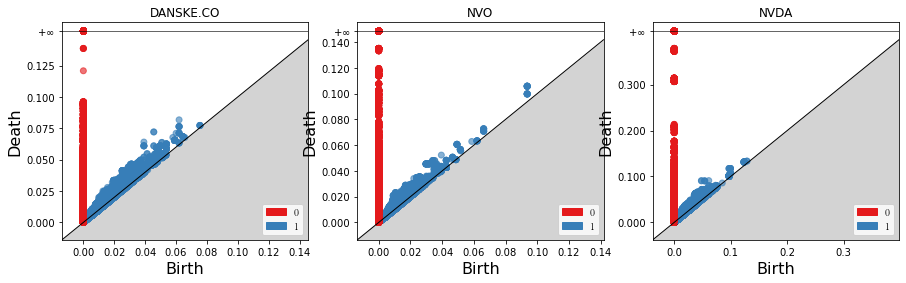

In [36]:
fig, ax = plt.subplots(1,3)
fig.set_figwidth(15)
gd.plot_persistence_diagram([pair for cplx in DK_complex for pair in cplx.persistence()], axes=ax[0])
gd.plot_persistence_diagram([pair for cplx in NVO_complex for pair in cplx.persistence()], axes=ax[1])
gd.plot_persistence_diagram([pair for cplx in NVDA_complex for pair in cplx.persistence()], axes=ax[2])
ax[0].set_title("DANSKE.CO")
ax[1].set_title("NVO")
ax[2].set_title("NVDA")
plt.tight_layout
plt.show()


#### g) Exploratory analysis
Below is a function that looks at "quiet" periods, and "not-quiet" periods (e.g. corona). Then it outputs 4 plots from these times. New $d$'s and $w$'s can then be tested

In [50]:
def testing(data, w, d, k, periods = [300, 1400, 3200, 4100], axes = None):
    """LEN MUST BE 4"""
    windows = sliding_window(time_delay(data,d),w)
    for i in range(len(periods)):
        p_pairs = gd.RipsComplex(points=windows[w+d+periods[i]]).create_simplex_tree(max_dimension = 2).persistence()
        gd.plot_persistence_diagram(p_pairs, axes=axes[i], fontsize=8)
        if i == 0: 
            s = f"w={w}, d={d} \n time ({periods[i]})"
        else: 
            s = f"time ({periods[i]})"
        axes[i].set_title(s)

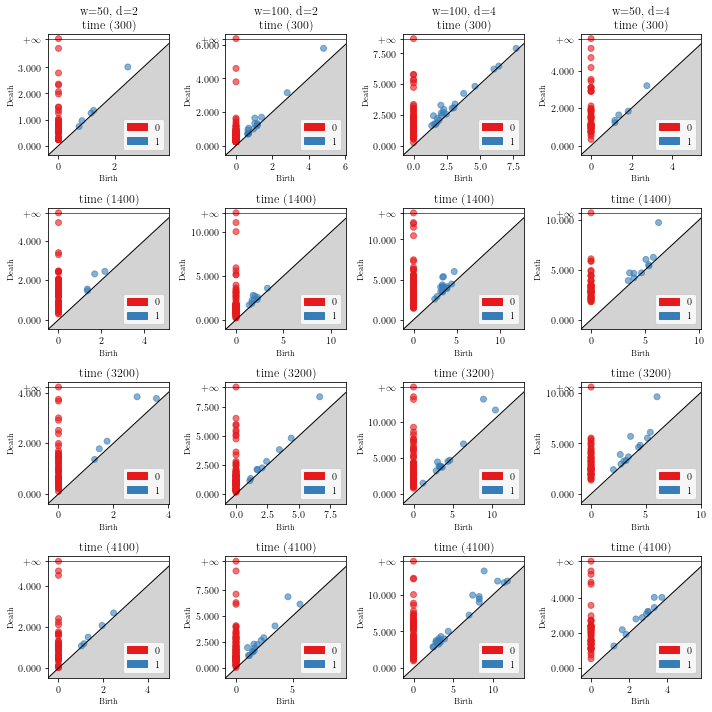

In [53]:
fig, ax = plt.subplots(4,4)
fig.set_size_inches(10,10)
testing(DK_close, w=50, d=2, k=0, axes=ax[:,0])
testing(DK_close, w=100, d=2, k=1, axes=ax[:,1])
testing(DK_close, w=100, d=4, k=2, axes=ax[:,2])
testing(DK_close, w=50, d=4, k=3, axes=ax[:,3])
plt.tight_layout()
plt.show()

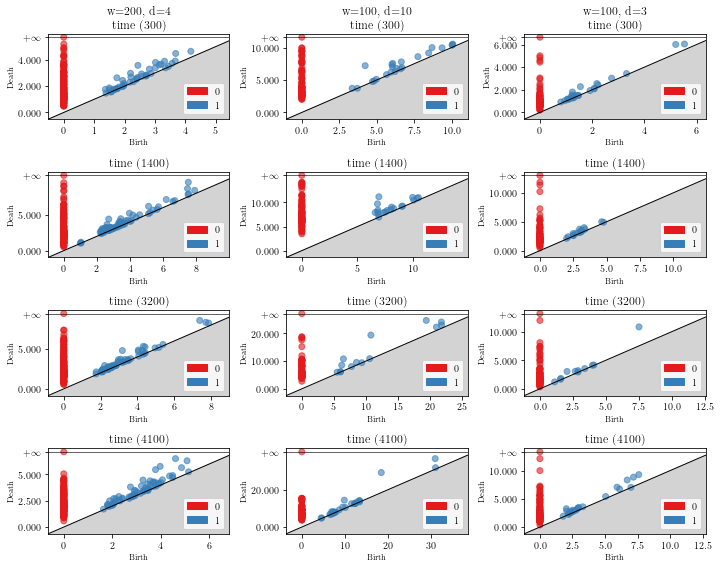

In [54]:
fig, ax = plt.subplots(4,3)
fig.set_size_inches(10,8)
testing(DK_close, w=200, d=4, k=0, axes=ax[:,0])
testing(DK_close, w=100, d=10, k=1, axes=ax[:,1])
testing(DK_close, w=100, d=3, k=2, axes=ax[:,2])
plt.tight_layout()
plt.show()

As seen above, the plot are relatively similar. But it could seem that $50$ points are too little. When increasing to $w = 200$, it seems mostly more noisy, and the added time compared to the extra information makes it seem like $100$ is the best choice.

It would also seem that $d$ does not change a whole lot, but there was a bit more "interesting" points when $d=4.$ And putting it to $10$ does not seem to change it a whole lot. So if we consider runtime of the algorithms, we will choose $d=4$

As for determining different market conditions from the diagrams, I do not see any obvious correlation. Maybe some $1$ dimensional features die a bit later when the period is volitile. And the birth-times are maybe earlier when the period is stable. 

So at the end, we make the data ready for using the explored $d$ and $w$.

In [30]:
del DK_complex # Just to clear up some RAM
del NVO_complex
del NVDA_complex

In [31]:
d = 4
w = 100
DK_persistance = complex_persistence(sliding_window(time_delay(log_return_DK,d),w), comp_per = True)
NVO_persistance = complex_persistence(sliding_window(time_delay(log_return_NVO,d),w), comp_per = True)
NVDA_persistance = complex_persistence(sliding_window(time_delay(log_return_NVDA,d),w), comp_per = True)

#### h) Persitent landscapes 
First we define a function to calculate all the landscapes

In [32]:
from gudhi.representations import Landscape
def landscapes(diagrams, resolution = 200, num_landscapes=1):
    """Diagrams are assumed to be of one dimension"""
    l = []
    for diag in diagrams:
        l.append(Landscape(num_landscapes=num_landscapes, resolution=resolution).fit_transform([diag])) # maybe only one.
    return l

In [33]:
DK_lands = landscapes(DK_persistance)
NVO_lands = landscapes(NVO_persistance)
NVDA_lands = landscapes(NVDA_persistance)

After having calculated the landscapes, we consider how different market conditions might show up

In [44]:
def land_test(data):
    periods = [0, 350, 1400, 1700, 2250, 2600, 3200, 4250, 4800]
    conds = ["calm", "calm", "volit", "calm", "volit", "calm", "volit", "volit", "volit"]
    fig, ax = plt.subplots(3,3)
    for i in range(9):
        ax[i%3,i//3].plot(data[periods[i]][0])
        ax[i%3,i//3].set_title(f"day {periods[i]} ({conds[i]})")
    plt.tight_layout()
    plt.show()

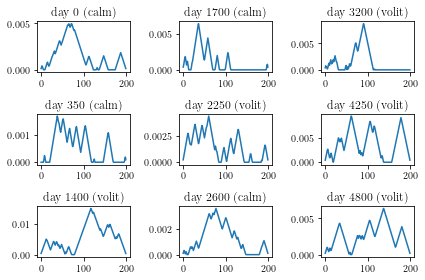

In [45]:
land_test(DK_lands)

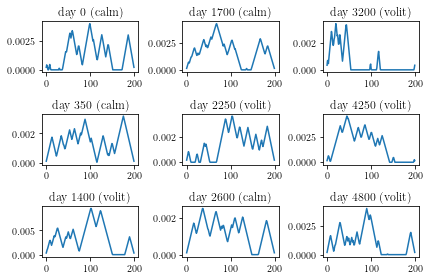

In [46]:
land_test(NVO_lands)

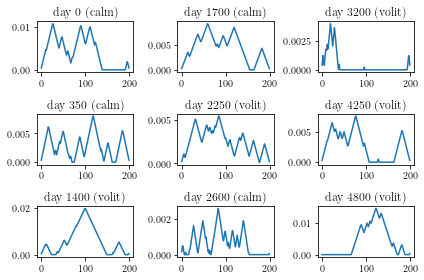

In [47]:
land_test(NVDA_lands)

It could look like the landscapes are higher in value, and maybe more spiked in more volitile periods. This is the most noticable difference. I do not see a huge difference in calm periods of increasing or deacresing stockprice. But the calm periods certainly have landscapes of lower values.

#### i) Compare the time series of the landscape norms with log-returns

In [87]:
def land_norms(data):
    new_data = np.array(data).reshape((len(data),200))
    out = (np.sum(new_data**2,1))**0.5
    return out

In [ ]:
# Landscape norms
DK_landnorm = land_norms(DK_lands)
NVO_landnorm = land_norms(NVO_lands)
NVDA_landnorm = land_norms(NVDA_lands)

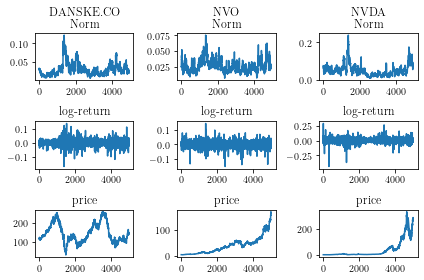

In [97]:
data = [DK_landnorm, log_return_DK, DK_close, NVO_landnorm, log_return_NVO, NVO_close, NVDA_landnorm, log_return_NVDA, NVDA_close]
label = ["Norm", "log-return", "price"]
names = ["DANSKE.CO", "NVO", "NVDA"]
fig, ax = plt.subplots(3,3)
for i in range(9):
    ax[i%3, i//3].plot(data[i])
    ax[i%3, i//3].set_title(f"{label[i%3]}")
    if i%3 == 0:
        ax[0, i//3].set_title(f"{names[i//3]}\n {label[0]}")
plt.tight_layout()

From considering these pictures, it would seem the landscape norm spikes, when the stock is in a volitile period. It is clearest on the DANSKE.CO stock, but if onelooks closely the NVDA stock is also very stable in price, until around 1600 days. Here it suddenly changes mean price. And that change is reflected by the spike probably. The NVO stock admits similar findings. 

These finding also make sense when we consider what we are actually doing. We each point we are making a landscape over consists of a set of prices for some $4$ days. Thus, if the price suddenly changes, the latest entry in this point / vector, will be noticably different from previously considered points. This will result in a point that lies farther from the other, i.e. a points that would "die" later in an eventual filtration. 

In other words. If the price quickly fluctuates a lot, the death times gets pushed back and thus the landscapes get higher. 

#### j) Use tests to test if the landscape norm differs by market period

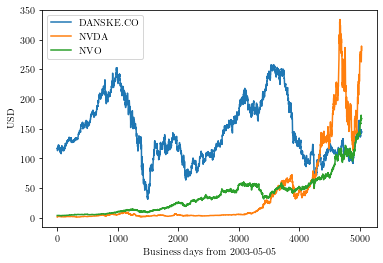

In [187]:
plt.plot(DK_close)
plt.plot(NVDA_close)
plt.plot(NVO_close)
plt.ylabel("USD")
plt.xlabel("Business days from 2003-05-05")
plt.legend(["DANSKE.CO", "NVDA", "NVO"])
plt.show()

I have chosen to do this in two ways. But to keep some amount of consistency the calm and volitile periods are chosen the same, for the two test. Now, depending on if we are testing whether the distribution of norms differ for the market as a whole, dependent on volitility, or if we are testing each stock, the periods whould be chosen either globally or for each stock.

I have chosen to consider if a period is deemed calm or volitile for each stock. This is done without looking at the landscapes, of course, however we are considering to closing price. However, when this is said, the periods seem overlap, since the market is intertwined. So the periods are the same in this case. (See the plots above)

The periods I will choose for the test are 

- Calm: $0-800$, and $2100-2900$, and maybe $3600-3800$

- Volitile: $1050-1250$ and $1950-2150$ and $4100-4300$. 

(The first volitile period is around $07-08$, the second is around $2011$, i.e. the beggining and the end of the great recession. The latter interval is when Corona crashed the markets.)

Notice that the calm periods are chosen such that the contain a lot of data. Then it is hopefully more representative. Note also, that the volitile periods are $200$ days to avoid any cherry picking, with instead giving the hypothesis an honest chance.

Lastly we consider the methods we use to try to conclude that the distributions differ. I do not have the insight to say a lot about an underlying distribution, so to assume as little as possible about this, I will use bootstrapping or similar methods.
- First we do a bootstrap for the means for the landscape norms.
The motivation here is, that if a sample mean of a volitile period often does not lie in the interval created by bootstrapping for means over a calm period, the distributions likely differ. So the null-hypothesis here (keeping in mind I haven't much experiance in creating a null-hypothesis) is $H_{0,1} = \mu_{calm} \approx \mu_{vol}$, within a $95$% confidence interval. 

The code for the bootstrap is seen below. I was unsure how best to do it. I will be sampling the size of the interval number of points from the calm periods with replacement. Then we calculate the mean, and repeat $10000$ times. Then we remove the lowest $2.5$% and the hight $2.5$% of the means and consider the inverval between these. Finally, we sample $200$ points from the volitile period with replacement, take the mean, consider if it lies in the priorly mentioned interval, and repeat.

In [188]:
def bootstraps(norm_data, resamples = 10000, test_n = 10000, s_size=None, axes = plt):
    calm_periods = [(0,800), (2100,2900), (3600,3800)]
    volitile_periods = [(0, 1050,1250), (1, 1950,2150), (2, 4100,4300)]
    mus = []
    for i in range(resamples):  # Bootstrap loop
        for start, end in calm_periods:
            mus.append(np.mean(np.random.choice(
                norm_data[start:end], replace=True, size=(s_size or end-start))))
    low_i = int(len(mus)*0.025)
    high_i = -low_i
    sort_mus = sorted(mus)
    band = (round(sort_mus[low_i],4), round(sort_mus[high_i],4))
    tests = np.array([0,0,0])
    avgs = [[],[],[]]
    for i in range(test_n):     # Testing periods against boostrap results
        for k, start, end in volitile_periods:
            avg = np.mean(np.random.choice(norm_data[start:end], replace=True, size=(s_size or 200)))
            avgs[k].append(avg)
            tests[k] += not(band[0] <avg< band[1]) # Counts how many times it fails
    out = tests/test_n
    axes.hist(mus, density=True, edgecolor="black")
    for i in range(3):
        axes.hist(avgs[i], density=True, alpha = 0.3, ls="dotted", edgecolor="grey")
    axes.legend(["calm", "07-08", "2011", "2020"])
    return (tuple(np.round(out, 4)), band)

##### Means

NAME      (07-08, 2011, 2020),    (low,high)
DANSKE.CO (1.0, 1.0, 1.0) (0.0173, 0.0277)
NVO       (1.0, 1.0, 0.6424) (0.0181, 0.0248)
NVDA      (1.0, 0.9688, 0.012) (0.0291, 0.0549)


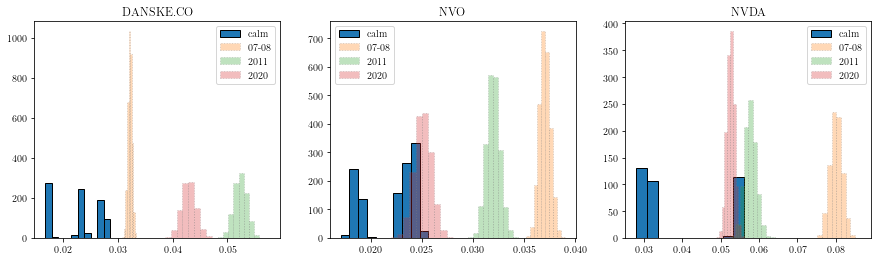

In [193]:
fig, ax = plt.subplots(1,3)
fig.set_figwidth(15)
print("NAME      (07-08, 2011, 2020),    (low,high)")
print("DANSKE.CO", *bootstraps(DK_landnorm, axes=ax[0]))
print("NVO      ", *bootstraps(NVO_landnorm, axes=ax[1]))
print("NVDA     ", *bootstraps(NVDA_landnorm, axes=ax[2]))
for i, name in enumerate(names):
    ax[i].set_title(name)
plt.show()

So for DANSKE.CO $100$% of the means always lie outside the interval (0.0173, 0.0277) from the bootstrap. For NVO, we have that $100$% of the means from 07-08 lie outside, which is also the case for 2011. However only $64$% lie outside in 2020. (The interval being 0.0181, 0.0248). Lastly for NVDA it is $100$%, $96$% and $01$% respectively. (The inverval being 0.0291, 0.0549).


Considering the above picture, a couple of things stand out.

- The "calm" is not connected. This is probably because the periods i have chosen are not equally calm. It is likely the period of points $3600-3800$, which is also evident if we run the function without it. This fact however only benifits the null-hypothesis in this setup.

- However, it would seem, only considering the means, one can quickly reject the null-hypothesis, since almost all norms from the volitile period lie away from the calm. Although there is a notable exeption. NVDA did very well when corona hit. This is probably because usecases for computational power was as highly demanded as ever (crypto, streaming, gamimng etc.), and only increased with time spent at home.

- The peaks are very tall, which hints that the spikes in the landscape norm series are few and far between for the average to get pulled down this far.

On the basis on the above, we therefore reject to null-hypothesis, that the means are close between periods of percieved calmness and volitility.

Next we test another null-hypothesis. Namely that the quantiles of a sample of landscape norms are close. I.e. $H_{0,2} = q_{calm} \approx q_{vol}$. This will be tested by sampling points from calm periods some amount of times with replacement. Then we discard the lowest and highest $5$% combined, and let an interval consist of the rest. Next we sample with replacement from the volitile periods some amount of times, and consider how many lie in the interval we just created. If the quantiles are different enough, hhis should hopefully also support a difference in distrubution.

Conveniently the code written to bootstrap is written with the purpose to also support this behaviour. If we in the function put sample size to $1$, it will only sample a single point at a time and then the above mentioned method is recovered:

##### Quantiles

NAME ,    (07-08, 2011, 2020),    (low,high)
DANSKE.CO (0.0, 0.6475, 0.3939) (0.0098, 0.0418)
NVO       (0.3531, 0.2247, 0.261) (0.0118, 0.0391)
NVDA      (0.4341, 0.1692, 0.0744) (0.0152, 0.0754)


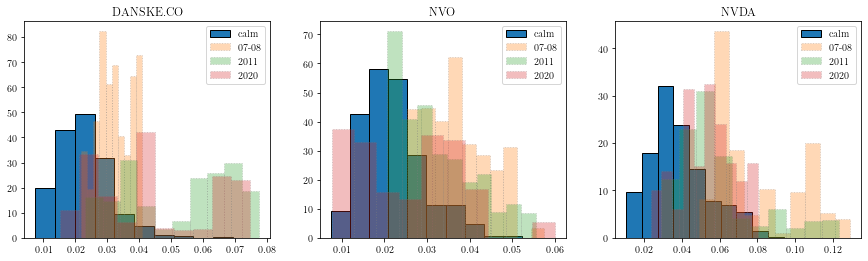

In [195]:
fig, ax = plt.subplots(1,3)
fig.set_figwidth(15)
print("NAME ,    (07-08, 2011, 2020),    (low,high)")
print("DANSKE.CO", *bootstraps(DK_landnorm, axes=ax[0], s_size=1, test_n=3333))
print("NVO      ", *bootstraps(NVO_landnorm, axes=ax[1], s_size=1, test_n=3333))
print("NVDA     ", *bootstraps(NVDA_landnorm, axes=ax[2], s_size=1, test_n=3333))
for i, name in enumerate(names):
    ax[i].set_title(name)
plt.show()

As before, we have for DANSKE.CO $0$%, $64$% and $39$% of the points from 07-08, 2011 and 2020 respectively, lie outside the interval $(0.0098, 0.0418)$. As for NVO it is $35$%, $22$% and $26$% respectively outside $(0.0118, 0.0391)$. Lastly, for NVDA it is $43$%, $16$% and $7$% outside the interval $(0.0152, 0.0754)$

The picture above is much less conclusive than the first one. However, there are still some amount points (much more than $5$%) from the percieved volitile periods norms, that lie outside the quantiles. But not all of the volitile periods are outside the quantiles. One could probably reject the null hypothesis for DANSKE.CO and NVDA. But NVO seems suprisngly stable in this chart, and not equally clear. 
Considering the distribution of the points, it does seems like there is a noticeble difference in underlying distributions dependent on market conditions, though. 